In [66]:
import torch
from PyLinq import PyLinqData
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")
else:
    print("CUDA is not available")
    device = torch.device("cpu")

# Move tensor to the GPU
x = torch.tensor([1.0])
x = x.to(device)
print(x)

CUDA is available
tensor([1.], device='cuda:0')


In [67]:
def en_passant_to_index(coordinate):
    # Convert the file into a 0-based index (a=0, b=1, ..., h=7)
    file_index = ord(coordinate[0].lower()) - ord('a')
    # Convert the rank into a 0-based index (8=0, 7=1, ..., 1=7)
    rank_index = 8 - int(coordinate[1])
    # Calculate the index in the uncompressed FEN string
    index = rank_index * 8 + file_index
    # Determine the appropriate character based on the rank
    en_passant_char = 'T' if coordinate[1] == '3' else 't'
    return index, en_passant_char

# Example usage:
# For a white pawn moving from e2 to e4, the en passant target is e3.
index, en_passant_char = en_passant_to_index('e3')
print(f"The index for the en passant target 'e3' is {index} and the character is '{en_passant_char}'.")


# # define the function to add the enpassant target rows
# def addEnpassantTargets(origRow, fen, i):
#     # create a string to represent the row
#     # throw an error if i is not 2 or 6
#     if(i != 2 and i != 5):
#         raise ValueError("i must be 2 or 6")
#     row = origRow
#     if(fen[3] != "-"):
#         if(int(fen[3][1]) == i + 1 or int(fen[3][1]) == i):
#             cols = "abcdefgh"
#             index = cols.index(fen[3][0])
#             # use the simplest notation to replace the character at the index with the t character
#             row = row[:index] + ("T" if i == 2 else "t") + row[index + 1:]
#     # set row to the 8 char substring of all starting at side * 8
#     return row

The index for the en passant target 'e3' is 44 and the character is 'T'.


In [68]:
def castlingRightsToString(castlingRights):
    # Define the order of castling rights as they should appear in the string
    orderedRights = "KQkq"
    # Use list comprehension to check for each right in orderedRights and replace with "-" if absent
    return ''.join(c if c in castlingRights else '-' for c in orderedRights)

def revertCastlingRights(paddedRights):
    # Filter out '-' characters and join the remaining characters to form the castling rights part of FEN
    castlingRights = ''.join(c for c in paddedRights if c != '-')
    # Return a dash if there are no castling rights, otherwise return the castling rights string
    return castlingRights if castlingRights else '-'

# test these functions with a variety of inputs such as KQkq, Kkq, KQk, KQ, K, Q, k, q, and the empty string
# create a list of standard FEN castling rights strings which are variable length
castlingRights = ["KQkq", "Kkq", "KQk", "KQ", "K", "Q", "k", "q", "-"]
# use the map function to apply the function to each element of the list and then back again and compare the final result with the original
# loop through each string in the list and outpt the result of the function and the original string to the console
convertedRights = list(map(castlingRightsToString, castlingRights))
revertedRights = list(map(revertCastlingRights, convertedRights))
# go throough each string in the list and print the original string and the result of the function in detail
for i in range(len(castlingRights)):
    print("Original: ", castlingRights[i], " Converted: ", convertedRights[i], " Reverted: ", revertedRights[i])

    

Original:  KQkq  Converted:  KQkq  Reverted:  KQkq
Original:  Kkq  Converted:  K-kq  Reverted:  Kkq
Original:  KQk  Converted:  KQk-  Reverted:  KQk
Original:  KQ  Converted:  KQ--  Reverted:  KQ
Original:  K  Converted:  K---  Reverted:  K
Original:  Q  Converted:  -Q--  Reverted:  Q
Original:  k  Converted:  --k-  Reverted:  k
Original:  q  Converted:  ---q  Reverted:  q
Original:  -  Converted:  ----  Reverted:  -


In [69]:

# generate some new categorical data for a new neural network
# the new data has enough columns to represent a variation of FEN notation for a chess board, where the / is left out because
# each row is represented in full without any compression of the empty squares
# here is an example of a normal FEN notation: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
# define a function to take the normal notation and convert it to a 64 column representation without slashes plus
# The full move and half move counts are discarded, but the move turn and castling rights are preserved
# here is an example of the conversion of the starting position: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1 to the new format
# rnbqkbnrpppppppp00000000000000000000000000000000PPPPPPPPRNBQKBNRwKQkq
# the first 64 columns represent the board, and the last 5 columns represent the move turn and castling rights
# the new data has 69 columns
def convertFEN(fen):
    # split the FEN into its 6 components
    fen = fen.split(" ")
    # split the board into its 8 rows
    board = fen[0].split("/")
    # create a new board with the rows combined and the empty squares compressed
    newBoard = ""
    for i in range(0, 8):
        # call a function to add the enpassant target rows if i has the value of 2 or 5
        for j in range(0, len(board[i])):
            if board[i][j].isdigit():
                for k in range(0, int(board[i][j])):
                    newBoard += "0"
            else:
                newBoard += board[i][j]
        # if i == 2 or i == 5:
        #     # pass the last 8 chars of newBoard into the enpassant function, then replace the last 8 chars of newBoard with the result
        #     newBoard = newBoard[:-8] + addEnpassantTargets(newBoard[-8:], fen, i)
            
    if fen[3] != "-":
        index, charEN = en_passant_to_index(fen[3])
        newBoard = newBoard[:index] + charEN + newBoard[index + 1:]

        # if fen[3][1] == "3":
        #     newBoard = newBoard[:index - 8] + "T" + newBoard[index - 7:]
        # else:
        #     newBoard = newBoard[:index + 8] + "t" + newBoard[index + 9:]

    # add the columns for move turn and castling rights
    newBoard += fen[1] + castlingRightsToString(fen[2])
    return newBoard


In [70]:
def revertFEN(custom_fen):
    # Find the en passant target and replace 't' or 'T' with '0'
    en_passant_target = '-'
    if 'T' in custom_fen or 't' in custom_fen:
        en_passant_char = 'T' if 'T' in custom_fen else 't'
        en_passant_target_index = custom_fen.index(en_passant_char)
        # Convert the index to a coordinate
        file = chr((en_passant_target_index % 8) + ord('a'))
        rank = str(8 - (en_passant_target_index // 8))
        en_passant_target = file + rank
        # Replace 't' or 'T' with '0'
        custom_fen = custom_fen[:en_passant_target_index] + '0' + custom_fen[en_passant_target_index+1:]

    # Initialize an empty list to hold the standard FEN ranks
    ranks = []
    # Process each rank in the custom FEN
    for rank_start in range(0, 64, 8):
        # Extract the current rank
        rank = custom_fen[rank_start:rank_start + 8]
        # Replace zeros with the appropriate number of empty squares
        standard_rank = ''
        empty_count = 0
        for char in rank:
            if char == '0':
                empty_count += 1
            else:
                if empty_count > 0:
                    standard_rank += str(empty_count)
                    empty_count = 0
                standard_rank += char
        if empty_count > 0:
            standard_rank += str(empty_count)
        # Add the processed rank to the list
        ranks.append(standard_rank)
    # Join the ranks with slashes to form the piece placement part of the standard FEN
    piece_placement = '/'.join(ranks)
    # Extract the remaining parts of the custom FEN
    move_turn = custom_fen[64]
    castling_rights = custom_fen[65:69].replace('-', '')
    # If there are no castling rights, represent with a dash
    castling_rights = castling_rights if castling_rights else '-'
    # Assemble the standard FEN
    return f"{piece_placement} {move_turn} {castling_rights} {en_passant_target}"

# Test the revertFEN function with the given custom FEN
standard_fen = "r1bqkbnr/ppp1pppp/n7/3pP3/8/8/PPPP1PPP/RNBQKBNR w KQkq d6 0 3"
custom_fen = convertFEN(standard_fen)
indexOfEnpassant,_ = en_passant_to_index('d6')
characterAtIndex = custom_fen[indexOfEnpassant]
rev_custom_fen = revertFEN(custom_fen)

assert len(custom_fen) == 69 # 64 for the board, 1 for move turn, 4 for castling rights
assert custom_fen[indexOfEnpassant] == 't'
assert rev_custom_fen in standard_fen

In [71]:
# test the function on the starting position
# test with a different FEN where a move sequence E2E4, etc that leads to a board position where enpassant is possible
fen1 = "r1bqkbnr/ppp1pppp/n7/3pP3/8/8/PPPP1PPP/RNBQKBNR w KQkq d6 0 3"
newBoard1 = convertFEN(fen1)
print(newBoard1)

fen2 = "r1bqkbnr/ppp1p1pp/n2P4/8/5pP1/N7/PPPP1P1P/R1BQKBNR b KQkq g3 0 5"
newBoard2 = convertFEN(fen2)
print(newBoard2)

fen3 = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
newBoard3 = convertFEN(fen3)
print(newBoard3)

fen4 = "2kr1bnr/pppqp1pp/n2P4/5b2/3P1B2/N5p1/PPPQ1P1P/R3KBNR w KQ - 5 9"
newBoard4 = convertFEN(fen4)
print(newBoard4)


r0bqkbnrppp0ppppn00t0000000pP0000000000000000000PPPP0PPPRNBQKBNRwKQkq
r0bqkbnrppp0p0ppn00P00000000000000000pP0N00000T0PPPP0P0PR0BQKBNRbKQkq
rnbqkbnrpppppppp00000000000000000000000000000000PPPPPPPPRNBQKBNRwKQkq
00kr0bnrpppqp0ppn00P000000000b00000P0B00N00000p0PPPQ0P0PR000KBNRwKQ--


In [72]:
#!pip install python-chess
import chess
import chess.pgn
import pandas as pd
import io

# Assuming convertFEN is defined as before and working correctly

# Sample PGN string for demonstration
pgn_string = """
[Event "NicosiaKyrenia's Study: Enpassant"]
[Site "https://lichess.org/study/WCSL1Ul1/YZoxPnWI"]
[Result "*"]
[Variant "Standard"]
[ECO "B00"]
[Opening "Lemming Defense"]
[Annotator "https://lichess.org/@/NicosiaKyrenia"]
[UTCDate "2024.02.18"]
[UTCTime "01:03:04"]

1. e4 Na6 2. e5 d5 3. exd6 f5 4. Na3 f4 5. g4 fxg3 *
"""

# Initialize pandas DataFrames for training data and labels
training_data = pd.DataFrame(columns=['CustomFEN'])
labels_data = pd.DataFrame(columns=['CustomFEN'])

# Read the PGN
pgn = io.StringIO(pgn_string)
game = chess.pgn.read_game(pgn)

# Initialize a board from the game
board = game.board()

for move in game.mainline_moves():
    # Generate standard FEN before the move
    fen_before = board.fen()
    # Convert to custom FEN and store as training data
    custom_fen_before = convertFEN(fen_before)
    training_data = pd.concat([training_data, pd.DataFrame({'CustomFEN': [custom_fen_before]})], ignore_index=True)
    
    # Apply the move on the board
    board.push(move)
    
    # Generate standard FEN after the move
    fen_after = board.fen()
    # Convert to custom FEN and store as label data
    custom_fen_after = convertFEN(fen_after)
    labels_data = pd.concat([labels_data, pd.DataFrame({'CustomFEN': [custom_fen_after]})], ignore_index=True)
    # custom_fen_after = convertFEN(fen_after)
    # labels_data = labels_data.append({'CustomFEN': custom_fen_after}, ignore_index=True)

# For demonstration, print the first few rows of each DataFrame
print(training_data.head())
print(labels_data.head())


                                           CustomFEN
0  rnbqkbnrpppppppp000000000000000000000000000000...
1  rnbqkbnrpppppppp00000000000000000000P000000000...
2  r0bqkbnrppppppppn0000000000000000000P000000000...
3  r0bqkbnrppppppppn00000000000P00000000000000000...
4  r0bqkbnrppp0ppppn00t0000000pP00000000000000000...
                                           CustomFEN
0  rnbqkbnrpppppppp00000000000000000000P000000000...
1  r0bqkbnrppppppppn0000000000000000000P000000000...
2  r0bqkbnrppppppppn00000000000P00000000000000000...
3  r0bqkbnrppp0ppppn00t0000000pP00000000000000000...
4  r0bqkbnrppp0ppppn00P00000000000000000000000000...


In [73]:
# This the following commented code is the general approach to go through the 
# training data and labels and convert the data to ordinal encoding
# convert the data into ordinal encoding for all columns
# for i in range(0, 69):
#     uniqueValues = np.unique(training_data.iloc[:, i]) # this line finds the unique values in the column
#     for j in range(0, len(uniqueValues)):
#         training_data.iloc[:, i] = np.where(training_data.iloc[:, i] == uniqueValues[j], j, training_data.iloc[:, i])
#         labels_data.iloc[:, i] = np.where(labels_data.iloc[:, i] == uniqueValues[j], j, labels_data.iloc[:, i])

# however, it is possible to synthesize the possible unique values for each column keeping in mind these rules:
# There are no pawns possible in rows 1 and 8
# Bishops can only be only be in the same color square as the starting square (not sure if that will help with ordinal encoding)
# There are only a few possible values for the castling rights and the move turn
# The enpassant target can only be in rows 3 and 6
# The enpassant target can only be in the same chess board column as the last move's pawn move (not sure if that will help with ordinal encoding)
# define a function to synthesize the possible unique values for each column of the training data and labels
# the function will return a list of the possible unique values for each column (don't know why it would be a list of lists)
# the function uniqueValuesPossibleForColumn will take a record and the column index as input and return the possible unique values for that column
# for i in range(0, 69):
#     uniqueValues = uniqueValuesPossibleForColumn(training_data.iloc[0, :], i)

def synthesize_custom_ordinal_values_final():
    ordinal_values = {}

    # Define all possible pieces, including uppercase for white and lowercase for black
    pieces_general = ['R', 'N', 'B', 'Q', 'K', 'P', 'r', 'n', 'b', 'q', 'k', 'p', '0']
    pieces_no_pawns = ['R', 'N', 'B', 'Q', 'K', 'r', 'n', 'b', 'q', 'k', '0']  # Exclude pawns in rows 1 and 8
    pieces_en_passant = ['R', 'N', 'B', 'Q', 'K', 'P', 'r', 'n', 'b', 'q', 'k', 'p', '0', 'T', 't']  # Include 't' for en passant
    
    # Assign possible values for each board square
    for i in range(64):
        row = i // 8 + 1
        if row in [1, 8]:
            ordinal_values[i] = pieces_no_pawns
        elif row in [3, 6]:  # Corrected rows for potential en passant targets, reflecting actual play possibilities
            ordinal_values[i] = pieces_en_passant
        else:
            ordinal_values[i] = pieces_general

    # Move turn possibilities
    ordinal_values[64] = ['w', 'b']
    
    # Castling rights - specific to each right, with '-' indicating the absence of the right
    ordinal_values[65] = ['K', '-']  # King-side for white
    ordinal_values[66] = ['Q', '-']  # Queen-side for white
    ordinal_values[67] = ['k', '-']  # King-side for black
    ordinal_values[68] = ['q', '-']  # Queen-side for black
    
    return ordinal_values

ordinal_values_final = synthesize_custom_ordinal_values_final()

# Example of accessing possible values for specific squares or data points
print("A1 square possibilities:", ordinal_values_final[0])  # Example for A1 square
print("Move turn possibilities:", ordinal_values_final[64]) # Example for move turn
print("First castling right possibility (King-side for white):", ordinal_values_final[65]) # Example for first castling right



A1 square possibilities: ['R', 'N', 'B', 'Q', 'K', 'r', 'n', 'b', 'q', 'k', '0']
Move turn possibilities: ['w', 'b']
First castling right possibility (King-side for white): ['K', '-']


In [74]:
# test some of the custom FENs with the ordinal encoding to make sure the encoding is working correctly
# for each custom FEN, go through each character and confirm that the character is in the possible unique values for that column
# if it is not, print an error message

for fen in [newBoard1, newBoard2, newBoard3, newBoard4]:
    for i, char in enumerate(fen):
        if char not in ordinal_values_final[i]:
            print(f"Error: {char} not in possible values for column {i}")


In [75]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# # Placeholder for the convertFEN function you provided earlier
# def convertFEN(fen):
#     # Your convertFEN function here
#     custom_fen = convertFEN(fen)
#     return custom_fen

# Function to encode a custom FEN string to numerical format
def encode_custom_fen(custom_fen):
    # Implement the encoding logic here, using the ordinal_values mapping
    # This is a placeholder function; you'll need to replace it with your actual encoding logic
    # encoded = np.array([ordinal_values[char] for char in custom_fen])
    # define a dictionary to hold the ordinal values for each piece.  Use negative numbers for black, and positive for white.
    # pawns are 1, knights are 3, bishops 3.5, rooks 5, queens 9, and kings 15
    pieceValues = {'R': 5, 'N': 3, 'B': 3.5, 'Q': 9, 'K': 15, 'P': 1, 'T': 1.3, 'r': -5, 'n': -3, 'b': -3.5, 'q': -9, 'k': -15, 'p': -1, 't': -1.3, '0': 0}
    moveTurn = {'w': 1, 'b': -1}
    # in general castlingRights = {'K': 1, 'Q': 1, 'k': -1, 'q': -1, '-': 0}
    # however it needs to be split into 4 separate dictionaries
    castlingRights1 = {'K': 1, '-': 0}
    castlingRights2 = {'Q': 1, '-': 0}
    castlingRights3 = {'k': -1, '-': 0}
    castlingRights4 = {'q': -1, '-': 0}
    # convert the custom FEN to a list of floats in a numpy array
    encoded = (np.array([pieceValues[char] for char in custom_fen[:64]] + 
                        [moveTurn[custom_fen[64]]] + 
                        [castlingRights1[char] for char in custom_fen[65]] +
                        [castlingRights2[char] for char in custom_fen[66]] +
                        [castlingRights3[char] for char in custom_fen[67]] +
                        [castlingRights4[char] for char in custom_fen[68]]))
    # make sure its a float array
    encoded = encoded.astype(float)    

    return encoded



In [76]:
def unencode_custom_fen(encoded_custom_fen):
    # Implement the decoding logic here, using the ordinal_values mapping
    # This is a placeholder function; you'll need to replace it with your actual decoding logic
    # decoded = np.array([ordinal_values[char].index(char) for char in custom_fen])
    # define a dictionary to hold the ordinal values for each piece.  Use negative numbers for black, and positive for white.
    # pawns are 1, knights are 3, bishops 3.5, rooks 5, queens 9, and kings 15
    pieceValues = {5: 'R', 3: 'N', 3.5: 'B', 9: 'Q', 15: 'K', 1: 'P', 1.3: 'T', -5: 'r', -3: 'n', -3.5: 'b', -9: 'q', -15: 'k', -1: 'p', -1.3: 't', 0: '0'}
    moveTurn = {1: 'w', -1: 'b'}
    # in general castlingRights = {1: 'K', 1: 'Q', -1: 'k', -1: 'q', 0: '-'}
    # but must be split into 4 separate dictionaries
    castlingRights1 = {1: 'K', 0: '-'}
    castlingRights2 = {1: 'Q', 0: '-'}
    castlingRights3 = {-1: 'k', 0: '-'}
    castlingRights4 = {-1: 'q', 0: '-'}

    # manually loop and convert the floats to the correct characters
    decoded = ""
    for i in range(0, 64):
        decoded += pieceValues[encoded_custom_fen[i]]
    decoded += moveTurn[encoded_custom_fen[64]]
    decoded += castlingRights1[encoded_custom_fen[65]]
    decoded += castlingRights2[encoded_custom_fen[66]]
    decoded += castlingRights3[encoded_custom_fen[67]]
    decoded += castlingRights4[encoded_custom_fen[68]]
                              
    return decoded


In [77]:


# ChessDataset class definition
class ChessDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# load csv called ../X_training_Y_Labels_Comment.csv and save the first column as training_data.csv and 
# the second column as labels_data.csv

# Load and preprocess the data, may be able to comment out after initial run
training_csv = '..\X_training_Y_Labels_Comment.csv'
# read it into numpy or pandas
training_df = pd.read_csv(training_csv)

# loop manually through each record to spot any anomalies
badCount = 0
indexListOfBad = []
# for i in range(0, len(training_df)):
#     # don't print anything unless there is an anomaly
#     # convert each FEN, 2 per record, to a custom FEN and then encode it
#     # each record consist of 2 FENs, the first is the input and the second is the output
#     # extract the first FEN
#     firstFEN = training_df.iloc[i, 0]
#     # and the second FEN
#     secondFEN = training_df.iloc[i, 1]
#     # convert the first FEN to a custom FEN and then encode it
#     convFirstFEN = convertFEN(firstFEN)
#     encConvFirstFEN = encode_custom_fen(convFirstFEN)
#     # convert the second FEN to a custom FEN and then encode it
#     convSecondFEN = convertFEN(secondFEN)
#     encConvSecondFEN = encode_custom_fen(convSecondFEN)
#     # convert encConvFirstFEN and encConvSecondFEN back to custom FENs
#     custEncConvFirstFEN = unencode_custom_fen(encConvFirstFEN)
#     custEncConvSecondFEN = unencode_custom_fen(encConvSecondFEN)
#     # convert them back to a FENs
#     regFirstFEN = revertFEN(custEncConvFirstFEN)
#     regSecondFEN = revertFEN(custEncConvSecondFEN)
#     # compare the original FEN with the new FEN.  If the new FEN is not 
#     # contained in the original FEN, increment badCount and add the index to the list
#     # define a boolean to see if the new FEN is contained in the original FEN
#     firstFENContained = regFirstFEN in firstFEN
#     secondFENContained = regSecondFEN in secondFEN
#     # if either is false increment badCount and add the index to the list
#     if not firstFENContained or not secondFENContained:
#         # TODO remove test code
#         regSecondFEN = revertFEN(custEncConvSecondFEN)

#         badCount += 1
#         indexListOfBad.append(i)
#     # of bad indices.  once done looping remove the bad records from the dataframe
#     # and print the bad count and the list of bad indices

print("The number of bad records is: ", badCount)
print("The list of bad indices is: ", indexListOfBad)
# remove the bad records from the dataframe
training_df = training_df.drop(indexListOfBad)



The number of bad records is:  0
The list of bad indices is:  []


In [78]:
# define a list of strings to hold X_convertFEN and another for y_convertFEN
X_convertFEN = []
y_convertFEN = []
# loop through each row of the dataframe and convert the FENs to custom FENs.  The first column contains X training data and the second column contains y labels
for i in range(0, len(training_df)):
    # convert each FEN, 2 per record, to a custom FEN and then encode it
    # each record consist of 2 FENs, the first is the input and the second is the output
    # extract the first FEN
    firstFEN = training_df.iloc[i, 0]
    # and the second FEN
    secondFEN = training_df.iloc[i, 1]
    # convert the first FEN to a custom FEN and then encode it
    convFirstFEN = convertFEN(firstFEN)
    convSecondFEN = convertFEN(secondFEN)
    X_convertFEN.append(convFirstFEN)
    y_convertFEN.append(convSecondFEN) 

# check that the length of the strings in both lists is always 69
for i in range(0, len(X_convertFEN)):
    if len(X_convertFEN[i]) != 69:
        print("The length of the string in X_convertFEN at index ", i, " is ", len(X_convertFEN[i]))
    if len(y_convertFEN[i]) != 69:
        print("The length of the string in y_convertFEN at index ", i, " is ", len(y_convertFEN[i]))

# convert the lists to numpy arrays by running each string through the encode_custom_fen function
X_raw = np.array([encode_custom_fen(fen) for fen in X_convertFEN])
y_raw = np.array([encode_custom_fen(fen) for fen in y_convertFEN])

# choose a random index into the trainging_df and define a simple list of strings variable fens to hold three FENs starting from that index
index = 0
fens = []
for i in range(index, index + 3):
    fens.append(training_df.iloc[i, 0])
    fens.append(training_df.iloc[i, 0])
    fens.append(training_df.iloc[i, 0])

# check that the shape of the arrays is (number of records, 69)
print(X_raw.shape)
print(y_raw.shape)

# Find the min and max values from the training data (X)
X_min = X_raw.min(axis=0)
X_max = X_raw.max(axis=0)

# Normalize both X and y using the Min-Max scaling method based on X's min and max
X = 2 * ((X_raw - X_min) / (X_max - X_min)) - 1
y = 2 * ((y_raw - X_min) / (X_max - X_min)) - 1

# print about 10 records to make sure the normalization worked
for i in range(0, 10):
    print(X[i])
    print(y[i])

# Split the dataset into training and validation sets
train_size = int(0.8 * len(X))
val_size = len(X) - train_size
X_train, X_val = np.split(X, [train_size])
y_train, y_val = np.split(y, [train_size])

# Create DataLoaders
train_dataset = ChessDataset(X_train, y_train)
val_dataset = ChessDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


import torch.nn as nn
import torch.nn.functional as F




(52154, 69)
(52154, 69)
[-0.33333333 -0.2        -0.23333333 -0.6        -1.         -0.23333333
 -0.2        -0.33333333 -0.06666667 -0.06666667 -0.06666667 -0.06666667
 -0.06666667 -0.06666667 -0.06666667 -0.06666667  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.06666667
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.06666667  0.06666667  0.06666667  0.          0.06666667  0.06666667
  0.06666667  0.06666667  0.16666667  0.2         0.23333333  0.6
  1.          0.23333333  0.2         0.33333333 -1.          1.
  1.         -1.         -1.        ]
[-0.33333333 -0.2        -0.23333333 -0.6        -1.         -0.23333333
  0.         -0.33333333 -0.06666667 -0.06666667 -0.06666667 -0.06666667
 -0.06666667 -0.06666667 -0.06666667 -0.0666

In [79]:
import torch.optim as optim
import matplotlib.pyplot as plt
# import torch to use the neural network
import torch
# proceed towards training the model to use ordinal encoded data
# define the model usint Tanh activation function
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Define the first layer with input size 69 and output size 202 (double the original middle layer size)
        self.layer1 = nn.Linear(69, 202)
        # Define the new middle layer with input size 202 and output size 202 (doubled size)
        self.layer2 = nn.Linear(202, 202)
        # Define the third layer symmetric to the first layer
        self.layer3 = nn.Linear(202, 202)
        # Define the fourth layer with output size 69, symmetric to the input layer
        self.layer4 = nn.Linear(202, 69)
        # Activation function
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.layer3(x)
        x = self.activation(x)
        x = self.layer4(x)
        x = self.activation(x)
        return x



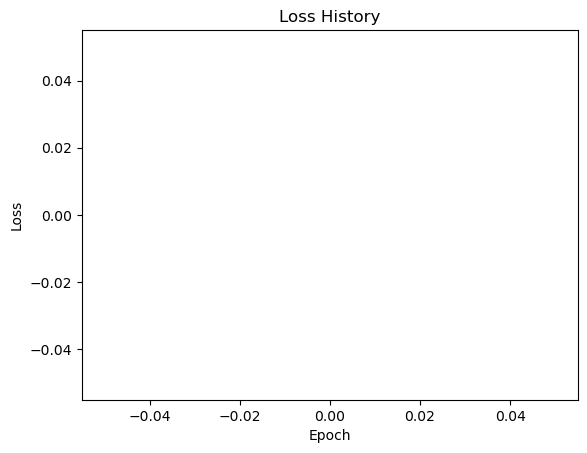

In [80]:
    
# create the neural network
neuralNetwork = NeuralNetwork()
neuralNetwork.to(device)

# create the loss function
criterion = nn.MSELoss()

# create the optimizer
optimizer = optim.Adam(neuralNetwork.parameters(), lr=0.0018)

# train the neural network
lossHistory = []
# for epoch in range(1500):
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         optimizer.zero_grad()
#         outputs = neuralNetwork(inputs.float())
#         loss = criterion(outputs.float(), labels.float())
#         loss.backward()
#         optimizer.step()
#     lossHistory.append(loss.item())
#     print("Epoch: ", epoch, " Loss: ", loss.item())

# # save the neural network
# torch.save(neuralNetwork.state_dict(), "model.pt")

# # save the loss history
# lossHistory = pd.DataFrame(lossHistory, columns=["Loss"])
# lossHistory.to_csv("loss_history.csv", index=False)

# plot the loss history
plt.plot(lossHistory)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss History")
plt.show()


In [81]:
# redo the using statements for inference, and then load the model

import torch
import numpy as np
import chess

# Assuming NeuralNetwork, encode_custom_fen, convertFEN, X_min, and X_max are defined elsewhere

class ChessAI:
    def __init__(self, model_path):
        self.neuralNetwork = NeuralNetwork()
        self.neuralNetwork.load_state_dict(torch.load(model_path))
        self.neuralNetwork.to(torch.device("cpu"))

    def predict(self, fen):
        input = self.prepare_input(fen)
        output = self.neuralNetwork(input).cpu().detach().numpy()
        return output

    def prepare_input(self, fen):
        input = encode_custom_fen(convertFEN(fen))
        input = 2 * ((input - X_min) / (X_max - X_min)) - 1
        return torch.tensor(input).float()

    def find_best_move(self, fen, output):
        board = chess.Board(fen)
        possibleMoves = list(board.legal_moves)
        newFENs = [self.make_move(board, move) for move in possibleMoves]
        encodedFENs = {fen: self.prepare_input(fen) for fen in newFENs}
        minLossIndex, _ = min(enumerate(encodedFENs.values()), key=lambda item: self.calculate_loss(item[1], output))
        return list(encodedFENs.keys())[minLossIndex]

    @staticmethod
    def make_move(board, move):
        board.push(move)
        fen = board.fen()
        board.pop()
        return fen

    @staticmethod
    def calculate_loss(predicted, actual):
        # Ensure both predicted and actual are NumPy arrays before subtraction and squaring
        predicted = predicted.numpy() if isinstance(predicted, torch.Tensor) else predicted
        actual = actual.numpy() if isinstance(actual, torch.Tensor) else actual
        return np.sum((predicted - actual) ** 2)


# Usage example
chess_ai = ChessAI("model.pt")
chosenFEN = "r3k2r/pp2nppp/2n5/3pP3/2q2Bb1/5N2/PP2NQPP/R3K2R w KQkq - 4 7"
output = chess_ai.predict(chosenFEN)
print("Predicted Output: ", np.round(output, 4))
best_move_fen = chess_ai.find_best_move(chosenFEN, output)
print("The FEN with the best move is: ", best_move_fen)






Predicted Output:  [-0.2989  0.0554 -0.0089 -0.0186 -0.9917 -0.0612 -0.0011 -0.3278 -0.0034
 -0.0377  0.0143  0.0612 -0.133  -0.0488 -0.0771 -0.0195  0.0037  0.015
 -0.2183 -0.0443 -0.0997  0.0136 -0.0599  0.0065  0.0283 -0.047   0.0052
 -0.0507  0.091   0.0148  0.0317 -0.0288  0.0092 -0.0159 -0.4428  0.0303
  0.0225  0.2251 -0.2374 -0.0071 -0.0195  0.015   0.0436  0.0229  0.003
  0.1577  0.0274  0.041   0.0778  0.0736  0.0115 -0.0686  0.2244  0.2903
  0.1251 -0.0261  0.143  -0.0419 -0.0533  0.0407  0.9858 -0.0023  0.0733
  0.379  -1.      0.9768  0.9565 -0.9998 -0.9994]
The FEN with the best move is:  r3k2r/pp2nppp/2n5/3pP3/2q2Bb1/5N1P/PP2NQP1/R3K2R b KQkq - 0 7


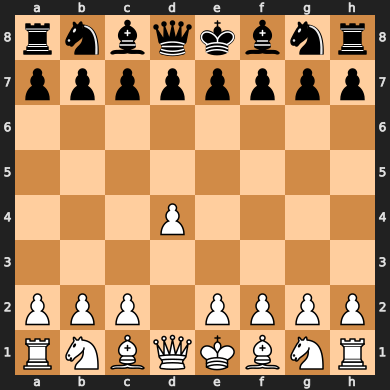

In [82]:
# define the functions needed to show a chess board, so that I can play against the neural network
# define a function to show a chess board
def showBoard(fen):
    # create a new board
    board = chess.Board(fen)
    
    # show the board
    display(board)

    return board

# define a function to play a game against the neural network

def get_best_move(fen, neural_network, X_min, X_max, encoded_fens):
    # Convert the FEN to a custom FEN and then encode it
    conv_fen = convertFEN(fen)
    enc_conv_fen = encode_custom_fen(conv_fen)
    
    # Normalize the input using the same scaling as the training data
    input = 2 * ((enc_conv_fen - X_min) / (X_max - X_min)) - 1
    input = torch.tensor(input).float()
    
    # Use the neural network to predict the output
    output = neural_network(input).cpu().detach().numpy()
    
    # Reverse the normalization of the neural network output
    output = (output + 1) / 2 * (X_max - X_min) + X_min
    
    # Calculate the loss for each possible move and find the one with the minimum loss
    min_loss = float('inf')
    best_move = None
    
    for fen, encoded_fen in encoded_fens.items():
        # Reverse the normalization of the encoded converted FEN
        encoded_fen = (encoded_fen + 1) / 2 * (X_max - X_min) + X_min
        
        # Calculate the loss
        loss = np.sum((output - encoded_fen) ** 2)
        
        # Update the best move if the loss is smaller
        if loss < min_loss:
            min_loss = loss
            best_move = fen
    
    # Return the best move or matching FEN
    return best_move

# Define the necessary variables
neural_network = NeuralNetwork()
neural_network.load_state_dict(torch.load("model.pt"))
neural_network.to(torch.device("cpu"))

# Define the encoded FENs dictionary
encoded_fens = {}
# display the board
bd = showBoard(fens[0])
# hook the event that is triggered when a move is made on the bd
def on_move_made(move):
    # get the new FEN
    newFEN = bd.fen()
    # convert the FEN to a custom FEN and then encode it
    convFEN = convertFEN(newFEN)
    encConvFEN = encode_custom_fen(convFEN)
    # add the encoded converted FEN to the dictionary
    encoded_fens[newFEN] = encConvFEN
    # get the best move from the neural network
    bestMove = get_best_move(newFEN, neural_network, X_min, X_max, encoded_fens)
    # Print the best move
    print("The best move to play against the neural network is:", bestMove)
# get the possible moves
# hook the event to the on_move_made function


In [83]:
# define fen_to_play from the board position just shown
fen_to_play = bd.fen()

# Get the best move from the neural network
best_move = get_best_move(fen_to_play, neural_network, X_min, X_max, encoded_fens)

# Print the best move
print("The best move to play against the neural network is:", best_move)



The best move to play against the neural network is: None
